<div align=center>
<font size=6>
<img src='https://drive.google.com/uc?id=1jQm5AkS-iTxZ8YoZpHL4a-fLQgVAcEbM'>
<p></p>
Financial Mathematics Project
<p></p>
Pricing and Hedging American Options using Deep Learning
<p></p>
<p></p>
</div>
</font>

<font size=5>
Authors:


*   Taha Akbari

*   Mahdi Hajialilue



</font>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
from itertools import product
from tqdm import tqdm
from gc import collect
from scipy.stats import norm
import seaborn as sns
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Normalization
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.utils import plot_model

In [ ]:
sns.set_theme()

# Generating the data

In [ ]:
# Set up the parameters
parameters = {
  'd': 5,
  'r': 0.05,
  'delta': 0.1,
  'sigma': 0.2,
  's0': 90,
  'rho': 0,
  'K': 100,
  'T': 3,
  'N': 9,
  'M': 12,
  'batch size': 8120,
  'price steps': 100,
  'hedge steps': 8,
  'lower bound samples': 1_024_000,
  'upper bound repeats': 512,
  'upper bound samples': 512,
  'hedging samples': 8192,
  'hedging error samples': 40_960
}

In [ ]:
def modify_parameters(parameters):
  modified_parameters = parameters.copy()
  modified_parameters['delta'] = 0
  modified_parameters['r'] = 0
  modified_parameters['N'] = modified_parameters['N'] * modified_parameters['M']
  return modified_parameters

number_of_samples brownian motions in time interval $[0, t]$ are generated by sampling independent increments from a gaussian distribution and calculating partial sums of increments.

The resulting array will be of shape (number of samples, time points, dimension)

In [ ]:
def brownian_motion(parameters, number_of_samples):
  samples = np.zeros((number_of_samples, parameters['N'] + 1, parameters['d']))
  time_delta = parameters['T'] / parameters['N']
  mean_vector = np.zeros(parameters['d'])
  correlation_matrix = np.ones((parameters['d'], parameters['d'])) * parameters['rho'] * time_delta + np.eye(parameters['d']) * (1 - parameters['rho']) * time_delta
  increments = np.random.multivariate_normal(mean_vector, correlation_matrix, size=(number_of_samples, parameters['N']))
  return np.cumsum(np.concatenate([np.zeros((number_of_samples, 1, parameters['d'])), increments], axis=1), axis=1)

For each brownian motion sample generates num_repeats continuations from each time point of the sample the continuation will be same until some specified time point and will be sampled independently afterwards.

The resulting array will be of shape (num of samples, distinction time point, number of repeats, time point, dimension).

In [ ]:
def continue_browian_motion(parameters, base_brownian_motion, num_repeats):
  number_of_samples = base_brownian_motion.shape[0]
  samples = np.zeros((number_of_samples, parameters['N'] + 1, num_repeats, parameters['N'] + 1, parameters['d']))
  time_delta = parameters['T'] / parameters['N']
  mean_vector = np.zeros(parameters['d'])
  correlation_matrix = np.ones((parameters['d'], parameters['d'])) * parameters['rho'] * time_delta + np.eye(parameters['d']) * (1 - parameters['rho']) * time_delta
  samples = base_brownian_motion[:, np.newaxis, np.newaxis, :, :] + samples
  for i in range(1, parameters['N'] + 1):
    samples[:, :i, :, i] = samples[:, :i, :, i - 1] + np.random.multivariate_normal(mean_vector, correlation_matrix, size=(number_of_samples, i, num_repeats))
  return samples

Creates stock prices processes based on brownian motion process. The processes are computed via the formula in the paper:

$$S_t ^ i = s_0 ^ i \exp([r - \delta_i - \sigma_i ^ 2 / 2]t + \sigma_iW_t^i),\quad i = 1, \dots, d$$

The resulting array will be of shape (number of samples, dimension).

In [ ]:
def stock_price_processes(parameters, number_of_samples, underlying_brownian_motion=None):
  if underlying_brownian_motion is None:
    underlying_brownian_motion = brownian_motion(parameters, number_of_samples)
  times = np.linspace(0, parameters['T'], underlying_brownian_motion.shape[1]).reshape((-1, 1))
  return parameters['s0'] * np.exp((parameters['r'] - parameters['delta'] - parameters['sigma'] ** 2 / 2) * times + parameters['sigma'] * underlying_brownian_motion)

Continues the stock prices in the same way as brownian motions.

In [ ]:
def continue_stock_prices(parameters, base_brownian_motion, num_repeats):
  continued_brownian_motion = continue_browian_motion(parameters, base_brownian_motion, num_repeats)
  times = np.linspace(0, parameters['T'], parameters['N'] + 1).reshape((-1, 1))
  return parameters['s0'] * np.exp((parameters['r'] - parameters['delta'] - parameters['sigma'] ** 2 / 2) * times + parameters['sigma'] * continued_brownian_motion)

Code to plot processes it takes an array of shape (time points, dimension) as input and plots each dimension separately in time.

In [ ]:
def plot_processes(samples, parameters):
  x = np.linspace(0, parameters['T'], parameters['N'] + 1)
  for i in range(samples.shape[1]):
    plt.plot(x, samples[:, i])

Plot of a 5 dimensonal brownian motion

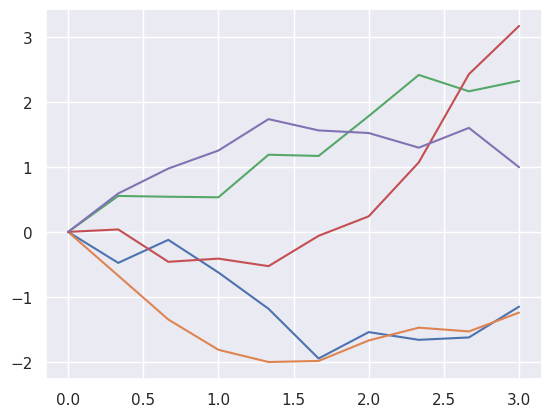

In [ ]:
samples = brownian_motion(parameters, 1)
plot_processes(samples[0], parameters)
del samples
collect();

Plot of single dimensional brownian motion continuations

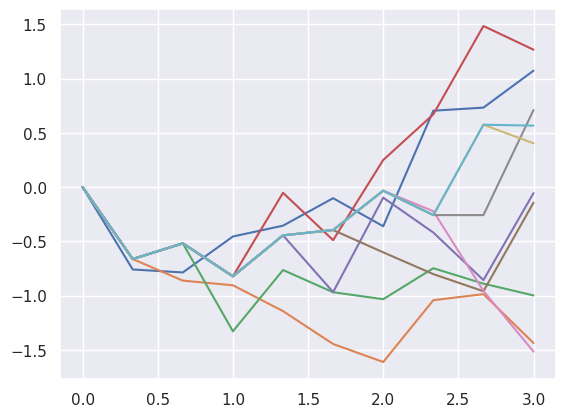

In [ ]:
samples = continue_browian_motion(parameters, brownian_motion(parameters, 1), 1)[0, :, 0, :, 0].T
plot_processes(samples, parameters)
del samples
collect();

Stock prices of 5 assets modeled by geometric brownian motion

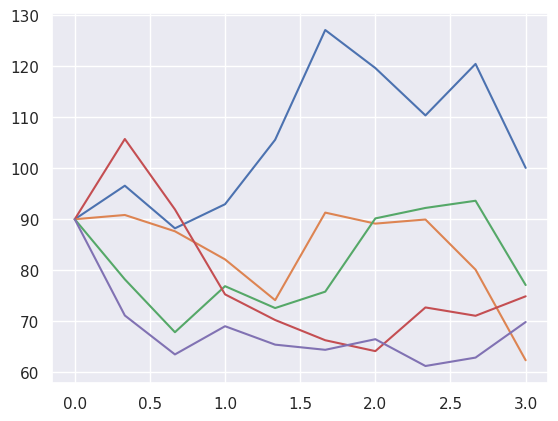

In [ ]:
prices = stock_price_processes(parameters, 1)
plot_processes(prices[0], parameters)
del prices
collect();

Plot of continuations of a stock price

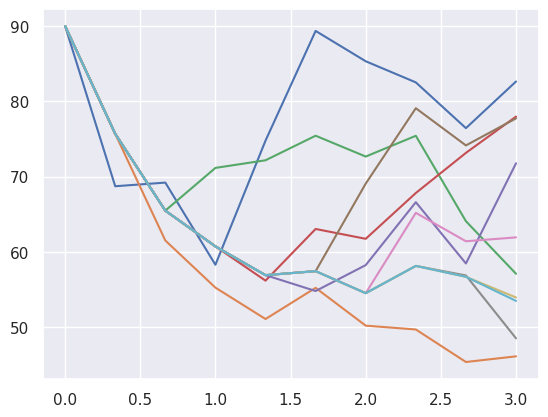

In [ ]:
samples = continue_stock_prices(parameters, brownian_motion(parameters, 1), 1)[0, :, 0, :, 0].T
plot_processes(samples, parameters)
del samples
collect();

Plot of hedging instruments (Each interval is split into $M$ subintervals).

3931

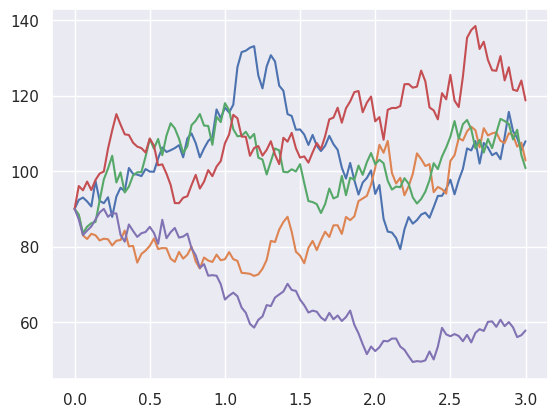

In [ ]:
samples = stock_price_processes(modify_parameters(parameters), 1)
plot_processes(samples[0], modify_parameters(parameters))
del samples
collect()

# Continuation value approximation

As suggested by the paper training the continuations values work more effectively when we used option payoff as an aditional feature. So we add a last dimension to our data namely:

$$\hat{X_n} = (X_1 ^ 1, \dots, X_n ^ d, X_n ^ {d + 1})$$

where we have defined:

$$X_n ^ {d + 1} = e ^ {-r\frac{nT}{n}}\left(\max\limits_{1 \le i \le d} X_n ^ i - k\right) ^ +$$

In [ ]:
def add_feature(samples, parameters):
  new_samples = np.zeros(samples.shape[:-1] + (samples.shape[-1] + 1,))
  times = np.linspace(0, parameters['T'], samples.shape[1])
  new_samples[..., :-1] = samples
  new_samples[..., -1] = np.maximum(samples.max(axis=-1) - parameters['K'], 0) * np.exp(-parameters['r'] * times)
  return new_samples

As suggested by the paper the model will be a neural network with two hidden layers of dimension $d + 50$ each and activation function of tanh followed by batch normalization.

In [ ]:
def get_continuation_value_model(parameters):
  model = Sequential([
      Dense(parameters['d'] + 50, activation='tanh', input_shape=(parameters['d'] + 1,)),
      BatchNormalization(),
      Dense(parameters['d'] + 50, activation='tanh'),
      BatchNormalization(),
      Dense(1)
  ])
  return model

In [ ]:
get_continuation_value_model(parameters).summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 55)                385       
                                                                 
 batch_normalization (BatchN  (None, 55)               220       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 55)                3080      
                                                                 
 batch_normalization_1 (Batc  (None, 55)               220       
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 1)                 56        
                                                                 
Total params: 3,961
Trainable params: 3,741
Non-trainabl

A predictor class providing same functionality as keras model but always predicting a constant will be used for model $0$ of the paper and an artificial last layer to make the code cleaner.

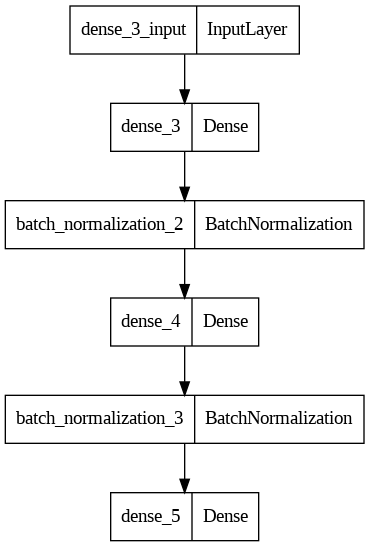

In [ ]:
plot_model(get_continuation_value_model(parameters))

In [ ]:
class predictor():
  def __init__(self, average):
    self.average = average

  def predict(self, x, batch_size=None, verbose=False):
    return np.ones(x.shape[0]) * self.average

  def __call__(self, x):
    return self.predict(x)

Learning rate scheduler suggested by the paper. The structure is a bit different from paper it starts with learning rate $0.001$ and divides it by $10$ after $1500$ batches.

In [ ]:
def lr_scheduler(epoch, lr):
  if epoch in [15]:
    return lr / 10
  else:
    return lr

The code for learning continuation values as explained in the paper the following steps are taken in order to fit the neural networks:

1.   Simulate paths $(x_n ^ k), k = 1, 2, \dots, K$ of the underlying process $(X_n)_{n = 0} ^ N$.

2.   Set $s_N ^ k \equiv N$ for all $k$. s_n will server as the optimal stopping times when we stop after step $n$.

3.   For $1 \le n \le N - 1$, approximate $\mathbb{E}[G_{\tau_{n + 1}}|X_n]$ with $c^{\theta _n}(X_n)$ by minimizing the sum:

$$\sum\limits_{k = 1} ^ K (g(s_{n + 1} ^ k, x_{s_{n + 1} ^ k} ^ k) - c^{\theta _n}(x_n ^ k)) ^ 2$$

4.   Set

$$s_n ^ k = \begin{cases}
      n & \text{if}\space\ g(n, x_n ^ k) \ge  c^{\theta _n}(x_n ^ k)\\
      s_{n + 1} ^ k & \text{otherwise}
  \end{cases}$$


5.   Define $\theta_0 := \frac{1}{K}\sum_{k = 1} ^ K g(s_1 ^ k, x_{s_1 ^ k} ^ k)$, and set $c ^ {\theta}$ constantly equal to $\theta_0$.


An aditional model predicting constantly infinity is added for convient. (You should never continue after time $n$ so the continuation value should be $-\infty$.





In [ ]:
def get_continuation_models(parameters):
  models = deque()
  optimal_stops = [parameters['N'] for _ in range(parameters['batch size'] * parameters['price steps'])]
  samples = add_feature(stock_price_processes(parameters, parameters['batch size'] * parameters['price steps']), parameters)
  for time in tqdm(range(parameters['N'] - 1, 0, -1)):
    X_train = samples[:, time, :]
    y_train = samples[range(parameters['batch size'] * parameters['price steps']), optimal_stops, -1]
    model = get_continuation_value_model(parameters)
    if models:
      model.set_weights(models[0].get_weights())
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.001))
    model.fit(X_train, y_train, epochs=30 if models else 60, batch_size=parameters['batch size'],validation_split=0.1, callbacks=[LearningRateScheduler(lr_scheduler), EarlyStopping(patience=100, restore_best_weights=True)], verbose=False)
    models.appendleft(model)
    continuations = model.predict(X_train, batch_size=parameters['batch size'], verbose=False)
    optimal_stops = [time if continuations[i] <= samples[i, time, -1] else optimal_stops[i] for i in range(parameters['batch size'] * parameters['price steps'])]
  average = np.array(samples[range(parameters['batch size'] * parameters['price steps']), optimal_stops, -1]).mean()
  models.appendleft(predictor(average))
  models.append(predictor(-float('inf')))
  return list(models)

A function to get the stopping times based on continuation value models based on the recursion:

$$\tau_n = \begin{cases}
      n & \text{if}\space\ G_n \ge \mathbb{E}[G_{\tau_{n + 1}}|X_n]\\
      \tau_{n + 1} & \text{otherwise}
  \end{cases}$$

we define stopping times as:

$$\tau ^ {\Theta} := \min \{ n \in \{0, 1, \dots, N - 1\} : g(n, X_n) \ge c ^ {\theta_n}(X_n) \}$$

We take a mask in each step which indicates which samples we have not reached stopping time yet. This helps vectorizing the computation and each time we give teh complete data of each time step as input instead of iterating over the samples.


In [ ]:
def get_stopping_times(parameters, models, samples):
  optimal_stops = np.array([parameters['N'] for _ in range(len(samples))])
  mask = np.ones(len(samples)).astype(np.bool8)
  for i in range(parameters['N']):
    bigger_mask = (samples[:, i, -1] >= models[i].predict(samples[:, i], batch_size=parameters['batch size']).squeeze())
    optimal_stops[np.logical_and(mask, bigger_mask)] = i
    mask = np.logical_and(mask, ~bigger_mask)
  return optimal_stops

# Get Lower bound and Upper bounds

## Lower bound

In this function we generate independent sample paths $(x_n ^ k)_{n = 0} ^ N, k = K, K + 1, \dots, K + K_L$, of $(X_n)_{n = 0} ^ N$ and approximate the lower bound $L$ with the monte carlo average:

$$\hat{L} = \frac{1}{K_L}\sum\limits_{k = K + 1} ^ {K + K_L} g^k$$

Where $g ^ k$ is the realization of $g(\tau ^ {\Theta}, X_{\tau ^ {\Theta}})$ along k'th sample.

Also by computing the sample standard deviation:

$$\hat{\sigma_L} = \sqrt{\frac{1}{K_L - 1}\sum\limits_{k = K + 1} ^ {K + K_L} (g^k - \hat{L}) ^ 2}$$

and using central limit theorem if we denote by $z_{\alpha / 2}$ the $1 - \alpha / 2$ quantile of standard normal distribution we an asymptotically valid $1 - \alpha / 2$ confidence interval:

$$\left[\hat{L} - z_{\alpha / 2}\frac{\hat{\sigma_L}}{\sqrt{K_L}}, \infty\right)$$

In [ ]:
def get_lower_bound(parameters, models):
  samples = add_feature(stock_price_processes(parameters, parameters['lower bound samples']), parameters)
  values = samples[range(len(samples)), get_stopping_times(parameters, models, samples), -1]
  return values.mean(), values.std() / np.sqrt(parameters['lower bound samples'])

## Upper bound

In order to compute the upper bound for the value of the option We need unbiased estimates of the continuation values based on computed stopping times. Taking exactly the result of model is obviously biased (because of using only one sample) In order to make it unbiased we generate several continuations for each path and time step and average the coresponding continuation values.

In [ ]:
def get_values_by_averaging(parameters, models, underlying_brownian_motion=None):
  if underlying_brownian_motion is None:
    underlying_brownian_motion = brownian_motion(parameters, parameters['upper bound samples'])
  continued_samples = add_feature(continue_stock_prices(parameters, underlying_brownian_motion, parameters['upper bound repeats']), parameters)
  values = continued_samples[..., -1, -1]
  for i in range(parameters['N']):
    time_i_values = values[:, i]
    mask = np.ones((parameters['upper bound samples'], parameters['upper bound repeats'])).astype(np.bool8)
    for j in range(i + 1, parameters['N']):
      bigger_mask = (continued_samples[:, i, :, j, -1].reshape((-1,)) >= models[j].predict(continued_samples[:, i, :, j].reshape((-1, parameters['d'] + 1)), batch_size=parameters['batch size']).squeeze()).reshape((parameters['upper bound samples'], parameters['upper bound repeats']))
      time_i_values[np.logical_and(mask, bigger_mask)] = continued_samples[:, i][np.logical_and(mask, bigger_mask)][:, j, -1]
      mask = np.logical_and(mask, ~bigger_mask)
    values[:, i, :] = time_i_values
  return values.mean(axis=2)


Uses unbiased estimates for the continuation values to compute martingale part of approximation for snell's envelope:

$$M_n ^ {\theta} - M_{n - 1} ^ {\theta} = 1_{\{C_N ^ {\Theta} \le g(n, X_n)\}} g(n, X_n) + 1_{\{C_N ^ {\Theta} > g(n, X_n)\}}C_n ^ {\theta} - C_{n - 1}$$

In [ ]:
def get_martingales(parameters, models, underlying_brownian_motion=None):
  if underlying_brownian_motion is None:
    underlying_brownian_motion = brownian_motion(parameters, parameters['upper bound samples'])
  samples = add_feature(stock_price_processes(parameters, parameters['upper bound samples'], underlying_brownian_motion), parameters)
  values = get_values_by_averaging(parameters, models, underlying_brownian_motion=underlying_brownian_motion)
  martingales = np.zeros((parameters['upper bound samples'], parameters['N'] + 1))
  for i in range(1, parameters['N'] + 1):
    if i == parameters['N']:
      martingales[:, i] = martingales[:, i - 1] + samples[:, i, -1] - values[:, i - 1]
    else:
      decisions = (samples[:, i, -1] >= models[i].predict(samples[:, i], batch_size=parameters['batch size']).squeeze())
      martingales[:, i] = martingales[:, i - 1] + decisions * samples[:, i, -1] + (1 - decisions) * values[:, i] - values[:, i - 1]
  return martingales

Computes the upper bound based on the relation:

$$V_0 \le \mathbb{E}\left[\max\limits_{0 \le n \le N} (g(n, X_n) - M_n - \epsilon_n)\right]$$

by generating independent relizations of $m_n ^ k$ of $M_n ^ {\theta} + \epsilon$ along independent relizations $(x_n ^ k)_{n = 0} ^ N, k = 1, \dots, K$ and estimates $U$ as:

$$\hat{U} = \frac{1}{K_u}\sum\limits_{k = K + K_L + 1} ^ {K + K_L + K_U} \max\limits_{0 \le n \le N} (g(n, x_n ^ k) - m_n ^ k)$$

based on the sample standard deviation:

$$\hat{U} = \sqrt{\frac{1}{K_u - 1}\sum\limits_{k = K + K_L + 1} ^ {K + K_L + K_U} (\max\limits_{0 \le n \le N} (g(n, x_n ^ k) - m_n ^ k) - \hat{U}) ^ 2}$$

We get the $1 - \alpha / 2$ confidence interval:

$$\left( -\infty, \hat{U} + z_{\alpha / 2}\frac{\hat{\sigma_U}}{\sqrt{K_u}}\right]$$



In [ ]:
def get_upper_bound(parameters, models):
  underlying_brownian_motion = brownian_motion(parameters, parameters['upper bound samples'])
  samples = add_feature(stock_price_processes(parameters, parameters['upper bound samples'], underlying_brownian_motion), parameters)
  martingales = get_martingales(parameters, models, underlying_brownian_motion)
  max_difference = (samples[..., -1] - martingales).max(axis=1)
  return max_difference.mean(), max_difference.std() / np.sqrt(len(max_difference))

The point estimate is given by:

$$\hat{V} = \frac{\hat{L} + \hat{U}}{2}$$

and $1 - \alpha$ confidence interval is given by:

$$\left[\hat{L} - z_{\alpha / 2}\frac{\hat{\sigma_L}}{\sqrt{K_L}}, \hat{U} + z_{\alpha / 2}\frac{\hat{\sigma_U}}{\sqrt{K_u}}\right]$$

In [ ]:
def get_point_estimate_and_confindence_interval(parameters, models):
  lower_bound_mean, lower_bound_std = get_lower_bound(parameters, models)
  upper_bound_mean, upper_bound_std = get_upper_bound(parameters, models)
  return (lower_bound_mean + upper_bound_mean) / 2, (lower_bound_mean + norm.ppf(0.125) * lower_bound_std, upper_bound_mean + norm.ppf(0.975) * upper_bound_std)

Estimates the price with a confidence interval based on the parameters in the paper.

In [ ]:
ds = [5, 10]
s0s = [90, 100, 110]
to_dataframe_list = []
for d, s0 in product(ds, s0s):
  parameters['s0'] = s0
  parameters['d'] = d
  continuation_models = get_continuation_models(parameters)
  point_estimate, confidence_interval = get_point_estimate_and_confindence_interval(parameters, continuation_models)
  to_dataframe_list.append([d, s0, point_estimate, f'[{confidence_interval[0]}, {confidence_interval[1]}]'])
  del continuation_models, point_estimate, confidence_interval
  collect()
price_estimation_results = pd.DataFrame(to_dataframe_list, columns=['d', 's0', 'Point Estimate', '95% confidence interval'])

100%|██████████| 8/8 [03:03<00:00, 22.97s/it]


1/1 [==============================] - 0s 20ms/step


100%|██████████| 8/8 [02:41<00:00, 20.14s/it]


1/1 [==============================] - 0s 17ms/step


100%|██████████| 8/8 [02:20<00:00, 17.59s/it]


1/1 [==============================] - 0s 20ms/step


100%|██████████| 8/8 [02:57<00:00, 22.16s/it]


1/1 [==============================] - 0s 19ms/step


100%|██████████| 8/8 [03:00<00:00, 22.59s/it]


1/1 [==============================] - 0s 18ms/step


100%|██████████| 8/8 [02:22<00:00, 17.86s/it]


1/1 [==============================] - 0s 19ms/step


The results are a bit less accurate than the paper due to shorter tarining time and using smaller samples because of RAM and GPU limits in colab but they are accurate enought to ensure the correctness of implementation.

In [ ]:
price_estimation_results

,d,s0,Point Estimate,95% confidence interval
0,5,90,16.583213,"[16.328291815860617, 16.925829869544604]"
1,5,100,26.066984,"[25.878481168374357, 26.33529173631315]"
2,5,110,36.656044,"[36.25839442892457, 37.16202627668781]"
3,10,90,26.087416,"[25.85291989546661, 26.413441582477905]"
4,10,100,38.092223,"[37.72118684121251, 38.5852557650039]"
5,10,110,50.621243,"[50.287022719046576, 51.062966013000384]"


## Hedging

The model we use for modeling amount of hedge there are two hidden layers with $d + 50$ layers and tanh activation function and batch normalization.

In [ ]:
def get_hedging_model(parameters):
  return Sequential([
      Dense(parameters['d'] + 50, activation='tanh', input_shape=(parameters['d'],)),
      BatchNormalization(),
      Dense(parameters['d'] + 50, activation='tanh'),
      BatchNormalization(),
      Dense(parameters['d'])
  ])

In [ ]:
get_hedging_model(parameters).summary()

Model: "sequential_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_150 (Dense)           (None, 60)                660       
                                                                 
 batch_normalization_100 (Ba  (None, 60)               240       
 tchNormalization)                                               
                                                                 
 dense_151 (Dense)           (None, 60)                3660      
                                                                 
 batch_normalization_101 (Ba  (None, 60)               240       
 tchNormalization)                                               
                                                                 
 dense_152 (Dense)           (None, 10)                610       
                                                                 
Total params: 5,410
Trainable params: 5,170
Non-train

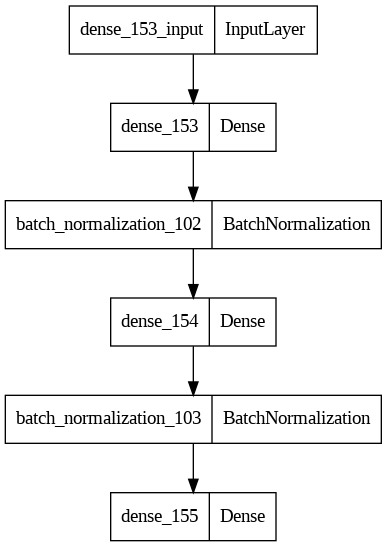

In [ ]:
plot_model(get_hedging_model(parameters))

Code to train simultaniously $M$ neural network to minimize hedging error in one subinterval.

The computation does not completely fit into a keras model so we create manually a training loop at each epoch the training loss is evaluated by summing up heding results in each interval and seeing how much we missed the on the hedge.

The weights of neural networks trained on previous subinterval are used to initialize the wights if they are given in previous_models argument.

The network parameters $h_{\lambda_m}$ are trained to minimize the error:


$$\sum\limits_{k = 1} ^ {K_H}(C ^ {\theta_{n - 1}}(y ^ k_{(n - 1)M}) + \sum\limits_{m = (n - 1)M} ^ {nM - 1} h ^ {\lambda_m}(y_m ^ k)\cdot(p_{m + 1}(y_{m + 1} ^ k )- p_m(y_m ^ k)) - v ^ {\theta_n}(y_{nM} ^ k)) ^ 2$$


Where $p_m$ is the value of hedging instruments at time $m$ and:

$$v ^ {\theta_n}(x) := g(n, x) \vee c ^ {\theta_n}(x)$$

The hedging instruments are also of the form:

$$P_{u_m} ^ i = s_0\exp (\sigma W_{u_m} ^ i - \sigma ^ 2 u_m / 2)$$

i.e stocks with dividends continuasly reinvested in the same stock.

In [ ]:
def train_single_interval(parameters, stock, hedging_instruments, continuation_models, epoch, previous_models=None):
  models = [get_hedging_model(parameters) for _ in range(parameters['M'])]
  if previous_models is not None:
    for model, copy_model in zip(models, previous_models):
      model.set_weights(copy_model.get_weights())
  weights = []
  for model in models:
    weights.extend(model.trainable_weights)
  optimizer = Adam()
  value_at_future = np.maximum(continuation_models[1].predict(stock[:, -1], verbose=False).squeeze(), stock[:, -1, -1].squeeze())
  pbar = tqdm(range(epoch))
  for _ in pbar:
    loss = 0
    with tf.GradientTape() as tape:
      predictions = tf.squeeze(continuation_models[0](stock[:, 0]))
      for i in range(parameters['M']):
        predictions = tf.add(tf.cast(predictions, tf.float32), tf.reduce_sum(models[i](stock[:, i, :-1]) * (hedging_instruments[:, i + 1, :-1] - hedging_instruments[:, i, :-1]), axis=1))
      loss = MeanSquaredError()(value_at_future, predictions)
    grads = tape.gradient(loss, weights)
    optimizer.apply_gradients(zip(grads, weights))
    pbar.set_description(f'loss: {float(loss.numpy())}')
  return models

Code to train the neural network for each sub interval.

In [ ]:
def get_hedging_models(parameters):
  modified_parameters = modify_parameters(parameters)
  underlying_brownian_motion = brownian_motion(modified_parameters, parameters['hedge steps'] * parameters['hedging samples'])
  stock = add_feature(stock_price_processes(parameters, parameters['hedge steps'] * parameters['hedging samples'], underlying_brownian_motion), parameters)
  hedging_instruments = add_feature(stock_price_processes(modified_parameters, parameters['hedge steps'] * parameters['hedging samples'], underlying_brownian_motion), modified_parameters)
  models = []
  for i in range(parameters['N']):
    models.extend(train_single_interval(parameters, stock[:, i * parameters['M']: (i + 1) * parameters['M'] + 1], hedging_instruments[:, i * parameters['M']: (i + 1) * parameters['M'] + 1], continuation_models[i:i + 2], 300 if i == 0 else 100, previous_models=None if i == 0 else models[-parameters['M']:]))
  return models

Calculate hedging error and hedging shortfall by creating independent samples and caculating the averaging hedging error and hedging shortfall for them.

In [ ]:
def get_hedging_error(parameters, hedging_models, continuation_models, one_step=False):
  modified_parameters = modify_parameters(parameters)
  underlying_brownian_motion = brownian_motion(modified_parameters, parameters['hedging error samples'])
  stock = add_feature(stock_price_processes(parameters, parameters['hedging error samples'], underlying_brownian_motion), parameters)
  hedging_instruments = add_feature(stock_price_processes(modified_parameters, parameters['hedging error samples'], underlying_brownian_motion), modified_parameters)
  stopping_times = get_stopping_times(parameters, continuation_models, stock[:, [i * parameters['M'] for i in range(parameters['N'] + 1)]]) * parameters['M']
  errors = np.ones(parameters['hedging error samples']) * continuation_models[0].average
  if one_step:
    errors -= np.maximum(continuation_models[1].predict(stock[:, parameters['M']]).squeeze(), stock[:, parameters['M'], -1])
  else:
    errors -= stock[range(len(stock)), stopping_times, -1]
  for time in range(parameters['M'] if one_step else parameters['M'] * parameters['N']):
    errors[stopping_times > time] += (hedging_models[time].predict(stock[:, time, :-1], batch_size=parameters['batch size']) * (hedging_instruments[:, time + 1, :-1] - hedging_instruments[:, time, :-1])).sum(axis=1)[stopping_times > time]
  return errors

Compute the hedging results on parameters specified in the paper.

In [ ]:
ds = [5]
s0s = [90, 100, 110]
ms = [12]
to_dataframe_list = []
for d, s0, m in product(ds, s0s, ms):
  collect()
  parameters['d'] = d
  parameters['s0'] = s0
  parameters['M'] = m
  continuation_models = get_continuation_models(parameters)
  hedging_models = get_hedging_models(parameters)
  one_step_errors = get_hedging_error(parameters, hedging_models, continuation_models, one_step=True)
  total_errors = get_hedging_error(parameters, hedging_models, continuation_models, one_step=False)
  to_dataframe_list.append([d, s0, m, one_step_errors.mean(), np.abs(one_step_errors[one_step_errors < 0]).mean(), np.abs(one_step_errors[one_step_errors < 0]).mean() / continuation_models[0].average,
                            total_errors.mean(), np.abs(total_errors[one_step_errors < 0]).mean(), np.abs(total_errors[one_step_errors < 0]).mean() / continuation_models[0].average])
  del continuation_models, hedging_models, one_step_errors, total_errors
  collect()
hedging_results = pd.DataFrame(to_dataframe_list, columns=['d', 's0', 'M', 'IHE', 'IHS', 'IHS / V', 'HE', 'HS', 'HS / V'])

loss: 13.22627067565918: 100%|██████████| 100/100 [00:57<00:00,  1.75it/s]


6/6 [==============================] - 0s 2ms/step


loss: 11.811767578125: 100%|██████████| 100/100 [00:56<00:00,  1.77it/s]


6/6 [==============================] - 0s 3ms/step


loss: 11.931385040283203: 100%|██████████| 100/100 [00:57<00:00,  1.75it/s]


6/6 [==============================] - 0s 2ms/step


Result for higher dimensions could not fit into RAM due to RAM limit of colab. The Heding Error and Hedging shortfall are small enough to ensure correctness of implementation.

In [ ]:
hedging_results

,d,s0,M,IHE,IHS,IHS / V,HE,HS,HS / V
0,5,90,12,0.712886,1.020717,0.061939,0.028708,4.896300,0.297115
1,5,100,12,0.513142,1.223778,0.047181,0.105874,4.658804,0.179612
2,5,110,12,-0.318863,1.517249,0.041512,0.104633,4.959441,0.135689


In [ ]:
parameters['d'] = 5
parameters['s'] = 90
parameters['m'] = 12
continuation_models = get_continuation_models(parameters)
hedging_models = get_hedging_models(parameters)
total_errors = get_hedging_error(parameters, hedging_models, continuation_models, one_step=False)

loss: 18.091604232788086: 100%|██████████| 100/100 [00:58<00:00,  1.71it/s]


6/6 [==============================] - 0s 2ms/step


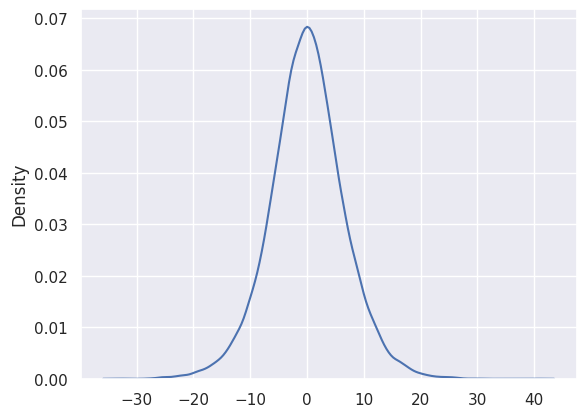

In [ ]:
sns.kdeplot(total_errors);